In [1]:
#from geoband.API import*
import pandas as pd
import geopandas as gpd
import numpy as np
import timeit
import json
import fiona
import os

import pydeck as pdk
import folium
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.family'] = 'Malgun Gothic'

from shapely.geometry import Polygon, LineString, Point
from tqdm import tqdm

In [13]:
# Accident_history_data = pd.read_csv("1.대전광역시_교통사고내역(2017~2019).csv") # 비공개 파일
Accident_grid_data = gpd.read_file("2.대전광역시_교통사고격자(2017~2019).geojson") # 비공개 파일
# Walking_light_data = gpd.read_file("3.대전광역시_신호등(보행등).geojson")
# Vehicle_light_data = gpd.read_file("4.대전광역시_신호등(차량등).geojson")
# Safe_zone_data = gpd.read_file("5.대전광역시_안전지대.geojson")
# Cross_walk_data = gpd.read_file("6.대전광역시_횡단보도.geojson")
# Road_speed_data = gpd.read_file("7.대전광역시_도로속도표시.geojson")
# No_stopping_data = gpd.read_file("8.대전광역시_정차금지지대.geojson")
# Traffic_safety_data = gpd.read_file("9.대전광역시_교통안전표지.geojson")
# Traffic_cctv_data = gpd.read_file("10.대전광역시_교통CCTV.geojson")
# Population_dong_data = pd.read_csv("11.대전광역시_동별_인구현황(2017~2019).csv")
# Population_total_data = gpd.read_file("12.대전광역시_인구정보(총인구).geojson")
# Population_old_data = gpd.read_file("13.대전광역시_인구정보(고령).geojson")
# Population_production_data = gpd.read_file("14.대전광역시_인구정보(생산가능).geojson")
# Population_youth_data = gpd.read_file("15.대전광역시_인구정보(유소년).geojson")
# Weather_data = pd.read_csv("16.대전광역시_기상데이터(2017~2019).csv")
Traffic_link_data = gpd.read_file("17.대전광역시_교통링크(2018).geojson")
Traffic_node_data = gpd.read_file("18.대전광역시_교통노드(2018).geojson")
Detail_road_data = gpd.read_file("19.대전광역시_상세도로망(2018).geojson") # 비공개 파일
Weekday_traffic_data = pd.read_csv("20.대전광역시_평일_일별_시간대별_추정교통량(2018).csv") # 비공개 파일
Congestion_freq_data = pd.read_csv("21.대전광역시_평일_일별_혼잡빈도강도(2018).csv") # 비공개 파일
Congestion_time_data = pd.read_csv("22.대전광역시_평일_일별_혼잡시간강도(2018).csv") # 비공개 파일
# Road_addr_data = gpd.read_file("23.대전광역시_도로명주소(건물).geojson")
# Building_area_data = gpd.read_file("24.대전광역시_건물연면적_격자.geojson")
# Boundary_city_data = gpd.read_file("25.대전광역시_법정경계(시군구).geojson")
# Boundary_dong_data = gpd.read_file("26.대전광역시_법정경계(읍면동).geojson")
# Boundary_admin_data = gpd.read_file("27.대전광역시_행정경계(읍면동).geojson")
Continuous_data = gpd.read_file("28.대전광역시_연속지적도.geojson")
Vehicle_regist_data = gpd.read_file("30.대전광역시_차량등록현황_격자.geojson")
# Median_separator_data = gpd.read_file("31.대전시_중앙분리대.geojson")

/opt/app-root/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
Accident_history_data

NameError: name 'Accident_history_data' is not defined

In [60]:
# 기준이 될 격자 데이터
gid_data = Vehicle_regist_data.loc[:, ['gid', 'geometry']]
gid_data

,gid,geometry
0,다마846996,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ..."
1,다마847995,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ..."
2,다마847996,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ..."
3,다마847997,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ..."
4,다마847998,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ..."
...,...,...
54907,라바052223,"MULTIPOLYGON (((127.55799 36.39818, 127.55799 ..."
54908,라바052224,"MULTIPOLYGON (((127.55799 36.39908, 127.55799 ..."
54909,라바053222,"MULTIPOLYGON (((127.55910 36.39727, 127.55910 ..."
54910,라바053223,"MULTIPOLYGON (((127.55910 36.39818, 127.55910 ..."


In [13]:
accident = pd.merge(Accident_history_data, gid_data, how='inner', on='gid') 
accident

,사고일,시군구,사고유형,법규위반,사고내용,사망자수,중상자수,경상자수,부상신고자수,가해운전자 차종,가해운전자 연령대,가해운전자 성별,피해운전자 차종,피해운전자 연령대,피해운전자 성별,gid,geometry
0,2017-01-01,대전광역시 서구 용문동,차대차 - 측면충돌,안전운전불이행,중상사고,0,1,1,0,승용,50대,남,승용,60대,남,다바905151,"MULTIPOLYGON (((127.39415 36.33323, 127.39415 ..."
1,2017-03-22,대전광역시 서구 용문동,차대차 - 측면충돌,안전거리미확보,중상사고,0,1,0,0,승용,40대,남,이륜,10대,남,다바905151,"MULTIPOLYGON (((127.39415 36.33323, 127.39415 ..."
2,2019-05-08,대전광역시 서구 용문동,차대차 - 추돌,안전운전불이행,경상사고,0,0,1,0,승용,50대,남,승용,50대,남,다바905151,"MULTIPOLYGON (((127.39415 36.33323, 127.39415 ..."
3,2019-11-28,대전광역시 서구 용문동,차대차 - 측면충돌,안전운전불이행,경상사고,0,0,1,0,승용,60대,여,자전거,50대,남,다바905151,"MULTIPOLYGON (((127.39415 36.33323, 127.39415 ..."
4,2017-01-01,대전광역시 서구 탄방동,차대차 - 추돌,안전운전불이행,경상사고,0,0,1,0,승용,50대,남,승용,30대,남,다바905166,"MULTIPOLYGON (((127.39413 36.34676, 127.39413 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23647,2018-07-17,대전광역시 서구 오동,차량단독 - 기타,기타,중상사고,0,1,0,0,승합,60대,남,NaN,NaN,NaN,다바822030,"MULTIPOLYGON (((127.30194 36.22403, 127.30194 ..."
23648,2018-10-17,대전광역시 서구 매노동,차대차 - 기타,안전운전불이행,사망사고,1,0,0,0,이륜,70대,남,승용,60대,남,다바842052,"MULTIPOLYGON (((127.32415 36.24390, 127.32415 ..."
23649,2018-10-20,대전광역시 서구 흑석동,차대사람 - 횡단중,안전운전불이행,중상사고,0,1,0,0,승용,50대,여,보행자,60대,여,다바857061,"MULTIPOLYGON (((127.34083 36.25203, 127.34083 ..."
23650,2018-10-23,대전광역시 서구 우명동,차대차 - 측면충돌,중앙선침범,경상사고,0,0,1,0,승용,60대,남,승용,20대,남,다바822036,"MULTIPOLYGON (((127.30193 36.22944, 127.30192 ..."


In [15]:
Accident_history_data.columns

Index(['사고일', '시군구', '사고유형', '법규위반', '사고내용', '사망자수', '중상자수', '경상자수', '부상신고자수',
       '가해운전자 차종', '가해운전자 연령대', '가해운전자 성별', '피해운전자 차종', '피해운전자 연령대',
       '피해운전자 성별', 'gid'],
      dtype='object')

In [14]:
Accident_history_data['gid'].value_counts()

다바888170    63
다바889169    62
다바889171    58
다바911168    56
다바825181    55
            ..
다바825204     1
다바929048     1
다바899267     1
다바956165     1
다바957177     1
Name: gid, Length: 6068, dtype: int64

In [22]:
Accident_history_data.groupby('gid').agg(np.mean)

,사망자수,중상자수,경상자수,부상신고자수
gid,,,,
다바780093,0.0,0.0,1.0,0.0
다바781090,0.0,0.0,2.0,0.0
다바781091,0.0,1.5,0.5,1.0
다바787132,0.0,1.0,0.0,0.0
다바787134,0.0,1.0,0.5,0.0
...,...,...,...,...
라바010169,0.5,0.0,3.0,0.0
라바016173,0.0,1.0,0.0,0.0
라바024244,1.0,0.0,0.0,0.0


In [ ]:
# # 최종 데이터
# final = pd.merge(gid_data, 붙일 데이터, how='inner', on='gid') # 한번에 하나씩만 가능
# final

## 
## 격자 내 차량등록 현황

In [5]:
vehicle_regist = Vehicle_regist_data[['gid', 'cars_cnt']]
vehicle_regist

,gid,cars_cnt
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [6]:
# 최종 데이터에 담기
final30 = pd.merge(gid_data, vehicle_regist, how='inner', on='gid')
final30

,gid,geometry,cars_cnt
0,다마846996,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ...",0
1,다마847995,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ...",0
2,다마847996,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ...",0
3,다마847997,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ...",0
4,다마847998,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ...",0
...,...,...,...
54907,라바052223,"MULTIPOLYGON (((127.55799 36.39818, 127.55799 ...",0
54908,라바052224,"MULTIPOLYGON (((127.55799 36.39908, 127.55799 ...",0
54909,라바053222,"MULTIPOLYGON (((127.55910 36.39727, 127.55910 ...",0
54910,라바053223,"MULTIPOLYGON (((127.55910 36.39818, 127.55910 ...",0


## 
## 격자 내 사고 현황

In [7]:
accident_grid = Accident_grid_data[['gid', 'acci_cnt']]
accident_grid

,gid,acci_cnt
0,다바866110,0
1,다바823157,0
2,다바928260,0
3,다바931203,2
4,다바836109,0
...,...,...
54907,다바861065,0
54908,다바912036,0
54909,다바867189,0
54910,다바851062,0


In [8]:
# 최종 데이터에 담기
final2 = pd.merge(final30, accident_grid, how='inner', on='gid')
final2

,gid,geometry,cars_cnt,acci_cnt
0,다마846996,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ...",0,0
1,다마847995,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ...",0,0
2,다마847996,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ...",0,0
3,다마847997,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ...",0,0
4,다마847998,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ...",0,0
...,...,...,...,...
54907,라바052223,"MULTIPOLYGON (((127.55799 36.39818, 127.55799 ...",0,0
54908,라바052224,"MULTIPOLYGON (((127.55799 36.39908, 127.55799 ...",0,0
54909,라바053222,"MULTIPOLYGON (((127.55910 36.39727, 127.55910 ...",0,0
54910,라바053223,"MULTIPOLYGON (((127.55910 36.39818, 127.55910 ...",0,0


## 
## 격자 내 안전지대 피쳐 생성

### 선택1. 원본 데이터 

In [ ]:
# 격자 내 안전지대 추출
sz_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_sz = Safe_zone_data['geometry'].intersects(gid).sum()
    sz_list.append(cnt_sz)
    
# 안전지대 컬럼 생성
s_zone = pd.DataFrame()
s_zone['gid'] = gid_data['gid']
s_zone['safe_zone'] = sz_list    

In [ ]:
# 격자 내 안전지대 데이터 csv로 저장
s_zone.to_csv("safe_zone.csv", index=False)
s_zone

In [9]:
s_zone = pd.read_csv('safe_zone.csv')
s_zone

,gid,safe_zone
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [10]:
# 최종 데이터에 담기
final5 = pd.merge(final2, s_zone, how='inner', on='gid')
final5

,gid,geometry,cars_cnt,acci_cnt,safe_zone
0,다마846996,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ...",0,0,0
1,다마847995,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ...",0,0,0
2,다마847996,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ...",0,0,0
3,다마847997,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ...",0,0,0
4,다마847998,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ...",0,0,0
...,...,...,...,...,...
54907,라바052223,"MULTIPOLYGON (((127.55799 36.39818, 127.55799 ...",0,0,0
54908,라바052224,"MULTIPOLYGON (((127.55799 36.39908, 127.55799 ...",0,0,0
54909,라바053222,"MULTIPOLYGON (((127.55910 36.39727, 127.55910 ...",0,0,0
54910,라바053223,"MULTIPOLYGON (((127.55910 36.39818, 127.55910 ...",0,0,0


### 선택2. 반경 50m 버퍼 데이터

In [ ]:
# 중심값 추출
Safe_zone_data['point'] = Safe_zone_data['geometry'].centroid
print(Safe_zone_data)

# 안전지대 좌표지정 후 지오메트리 추출
pts = gpd.GeoDataFrame(Safe_zone_data['point'], geometry='point')
pts.crs = {'init':'epsg:4326'} 
pts = pts.to_crs({'init':'epsg:5181'}) 
print(pts.crs)

# 반경 50미터 버퍼 생성
buf = pts.buffer(50) 
print(buf.crs)
buf = buf.to_crs({'init':'epsg:4326'}) 
print(buf.crs)

In [ ]:
# 안전지대 반경 50m 데이터
safe_zone_buf = Safe_zone_data[['dong']]
safe_zone_buf['point'] = buf
safe_zone_buf = gpd.GeoDataFrame(safe_zone_buf)
print(safe_zone_buf)

# jeojson파일로 저장
safe_zone_buf.to_file('안전지대반경50m.geojson', driver = 'GeoJSON', index=False)

In [ ]:
# 격자 내 안전지대 반경 50m 추출
szb_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_szb = safe_zone_buf['point'].intersects(gid).sum()
    szb_list.append(cnt_szb)
    
# 안전지대 반경 50m 컬럼 생성
s_zone50 = pd.DataFrame()
s_zone50['gid'] = gid_data['gid']
s_zone50['safe_zone50m'] = szb_list  

In [ ]:
# 격자 내 안전지대 데이터 반경 50m csv로 저장
s_zone50.to_csv("safe_zone50m.csv", index=False)
s_zone50

In [ ]:
# # 최종 데이터에 담기
# final5 = pd.merge(final2, s_zone50, how='inner', on='gid')
# final5

## 
## 격자 내 횡단보도 피쳐 생성

### 선택1. 원본 데이터 

In [ ]:
# 격자 내 횡단보도 추출
cw_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_cw = Cross_walk_data['geometry'].intersects(gid).sum()
    cw_list.append(cnt_cw)
    
# 횡단보도 컬럼 생성
cross_w = pd.DataFrame()
cross_w['gid'] = gid_data['gid']
cross_w['cross_walk'] = cw_list

In [ ]:
# 격자 내 횡단보도 데이터 csv로 저장
cross_w.to_csv("cross_walk.csv", index=False)
cross_w

In [11]:
cross_w = pd.read_csv('cross_walk')
cross_w

,gid,CW_cnt
0,다바866110,0
1,다바823157,5
2,다바928260,5
3,다바931203,1
4,다바836109,2
...,...,...
54907,다바861065,0
54908,다바912036,0
54909,다바867189,0
54910,다바851062,0


In [12]:
# 최종 데이터에 담기
final6 = pd.merge(final5, cross_w, how='inner', on='gid')
final6

,gid,geometry,cars_cnt,acci_cnt,safe_zone,CW_cnt
0,다마846996,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ...",0,0,0,0
1,다마847995,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ...",0,0,0,0
2,다마847996,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ...",0,0,0,0
3,다마847997,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ...",0,0,0,0
4,다마847998,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ...",0,0,0,0
...,...,...,...,...,...,...
54907,라바052223,"MULTIPOLYGON (((127.55799 36.39818, 127.55799 ...",0,0,0,0
54908,라바052224,"MULTIPOLYGON (((127.55799 36.39908, 127.55799 ...",0,0,0,0
54909,라바053222,"MULTIPOLYGON (((127.55910 36.39727, 127.55910 ...",0,0,0,0
54910,라바053223,"MULTIPOLYGON (((127.55910 36.39818, 127.55910 ...",0,0,0,0


### 선택2. 반경 50m 버퍼 데이터

In [ ]:
# 중심값 추출
Cross_walk_data['point'] = Cross_walk_data['geometry'].centroid
print(Cross_walk_data)

# 횡단보도 좌표지정 후 지오메트리 추출
pts = gpd.GeoDataFrame(Cross_walk_data['point'], geometry='point')
pts.crs = {'init':'epsg:4326'} 
pts = pts.to_crs({'init':'epsg:5181'}) 
print(pts.crs)

# 반경 50미터 버퍼 생성
buf = pts.buffer(50) 
print(buf.crs)
buf = buf.to_crs({'init':'epsg:4326'}) 
print(buf.crs)

In [ ]:
# 횡단보도 반경 50m 데이터
cross_walk_buf = Cross_walk_data[['dong', 'crsw_knd_cd']]
cross_walk_buf['point'] = buf
cross_walk_buf = gpd.GeoDataFrame(cross_walk_buf)
print(cross_walk_buf)

# jeojson파일로 저장
cross_walk_buf.to_file('횡단보도반경50m.geojson', driver = 'GeoJSON', index=False)

In [ ]:
# 격자 내 횡단보도 반경 50m 추출
cwb_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_cwb = cross_walk_buf['point'].intersects(gid).sum()
    cwb_list.append(cnt_cwb)
    
# 안전지대 반경 50m 컬럼 생성
cross_w50 = pd.DataFrame()
cross_w50['gid'] = gid_data['gid']
cross_w50['cross_walk50m'] = cwb_list  

In [ ]:
# 격자 내 횡단보도 데이터 반경 50m csv로 저장
cross_w50.to_csv("cross_walk50m.csv", index=False)
cross_w50

In [ ]:
# # 최종 데이터에 담기
# final6 = pd.merge(final5, cross_w50, how='inner', on='gid')
# final6

## 
## 격자 내 교통안전표지 피쳐 생성

### 선택1. 원본 데이터 

In [9]:
# 격자 내 교통안전표지 추출
ts_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_ts = Traffic_safety_data['geometry'].intersects(gid).sum()
    ts_list.append(cnt_ts)
    
# 교통안전표지 컬럼 생성
t_sign = pd.DataFrame()
t_sign['gid'] = gid_data['gid']
t_sign['traffic_sign'] = ts_list

100%|██████████| 54912/54912 [2:27:19<00:00,  6.21it/s]  


In [10]:
# 격자 내 교통안전표지 데이터 csv로 저장
t_sign.to_csv("traffic_sign.csv", index=False)
t_sign

,gid,traffic_sign
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [13]:
t_sign = pd.read_csv('traffic_sign.csv')
t_sign

,gid,traffic_sign
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [14]:
# 최종 데이터에 담기
final9 = pd.merge(final6, t_sign, how='inner', on='gid')
final9

,gid,geometry,cars_cnt,acci_cnt,safe_zone,CW_cnt,traffic_sign
0,다마846996,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ...",0,0,0,0,0
1,다마847995,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ...",0,0,0,0,0
2,다마847996,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ...",0,0,0,0,0
3,다마847997,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ...",0,0,0,0,0
4,다마847998,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ...",0,0,0,0,0
...,...,...,...,...,...,...,...
54907,라바052223,"MULTIPOLYGON (((127.55799 36.39818, 127.55799 ...",0,0,0,0,0
54908,라바052224,"MULTIPOLYGON (((127.55799 36.39908, 127.55799 ...",0,0,0,0,0
54909,라바053222,"MULTIPOLYGON (((127.55910 36.39727, 127.55910 ...",0,0,0,0,0
54910,라바053223,"MULTIPOLYGON (((127.55910 36.39818, 127.55910 ...",0,0,0,0,0


### 선택2. 반경 50m 버퍼 데이터

In [ ]:
# 교통안전표지 좌표지정 후 지오메트리 추출
pts = gpd.GeoDataFrame(Traffic_safety_data['geometry'], geometry='geometry')
pts.crs = {'init':'epsg:4326'} 
pts = pts.to_crs({'init':'epsg:5181'}) 
print(pts.crs)

# 반경 50미터 버퍼 생성
buf = pts.buffer(50) 
print(buf.crs)
buf = buf.to_crs({'init':'epsg:4326'}) 
print(buf.crs)

In [ ]:
# 교통안전표지 반경 50m 데이터
traffic_safety_buf = Traffic_safety_data # [['dong']] 쓸만한 칼럼 선택
traffic_safety_buf['geometry'] = buf
traffic_safety_buf = gpd.GeoDataFrame(traffic_safety_buf)
print(traffic_safety_buf)

# jeojson파일로 저장
traffic_safety_buf.to_file('교통안전표지반경50m.geojson', driver = 'GeoJSON', index=False)

In [ ]:
# 격자 내 교통안전표지 반경 50m 추출
tsb_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_tsb = cross_walk_buf['geometry'].intersects(gid).sum()
    tsb_list.append(cnt_tsb)
    
# 교통안전표지 반경 50m 컬럼 생성
t_sign50 = pd.DataFrame()
t_sign50['gid'] = gid_data['gid']
t_sign50['traffic_sign50m'] = tsb_list  

In [ ]:
# 격자 내 교통안전표지 반경 50m 데이터 csv로 저장
t_sign50.to_csv("traffic_sign50m.csv", index=False)
t_sign50

In [ ]:
# # 최종 데이터에 담기
# final9 = pd.merge(final6, t_sign50, how='inner', on='gid')
# final9

## 
## 격자 내 교통CCTV 피쳐 생성

### 선택1. 원본 데이터 

In [11]:
# 격자 내 교통CCTV 추출
cc_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_cc = Traffic_cctv_data['geometry'].intersects(gid).sum()
    cc_list.append(cnt_cc)
    
# 교통CCTV 컬럼 생성
t_cctv = pd.DataFrame()
t_cctv['gid'] = gid_data['gid']
t_cctv['traffic_cctv'] = cc_list

100%|██████████| 54912/54912 [00:44<00:00, 1241.78it/s]


In [12]:
# 격자 내 교통CCTV 데이터 csv로 저장
t_cctv.to_csv("traffic_cctv.csv", index=False)
t_cctv

,gid,traffic_cctv
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [15]:
t_cctv = pd.read_csv('traffic_cctv.csv')
t_cctv

,gid,traffic_cctv
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [16]:
# 최종 데이터에 담기
final10 = pd.merge(final9, t_cctv, how='inner', on='gid')
final10

,gid,geometry,cars_cnt,acci_cnt,safe_zone,CW_cnt,traffic_sign,traffic_cctv
0,다마846996,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ...",0,0,0,0,0,0
1,다마847995,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ...",0,0,0,0,0,0
2,다마847996,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ...",0,0,0,0,0,0
3,다마847997,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ...",0,0,0,0,0,0
4,다마847998,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
54907,라바052223,"MULTIPOLYGON (((127.55799 36.39818, 127.55799 ...",0,0,0,0,0,0
54908,라바052224,"MULTIPOLYGON (((127.55799 36.39908, 127.55799 ...",0,0,0,0,0,0
54909,라바053222,"MULTIPOLYGON (((127.55910 36.39727, 127.55910 ...",0,0,0,0,0,0
54910,라바053223,"MULTIPOLYGON (((127.55910 36.39818, 127.55910 ...",0,0,0,0,0,0


### 선택2. 반경 50m 버퍼 데이터

In [ ]:
# 교통CCTV 좌표지정 후 지오메트리 추출
pts = gpd.GeoDataFrame(Traffic_cctv_data['geometry'], geometry='geometry')
pts.crs = {'init':'epsg:4326'} 
pts = pts.to_crs({'init':'epsg:5181'}) 
print(pts.crs)

# 반경 50미터 버퍼 생성
buf = pts.buffer(50) 
print(buf.crs)
buf = buf.to_crs({'init':'epsg:4326'}) 
print(buf.crs)

In [ ]:
# 교통CCTV 반경 50m 데이터
traffic_cctv_buf = Traffic_cctv_data[['dong']]
traffic_cctv_buf['geometry'] = buf
traffic_cctv_buf = gpd.GeoDataFrame(traffic_cctv_buf)
print(traffic_cctv_buf)

# jeojson파일로 저장
traffic_cctv_buf.to_file('교통안전표지반경50m.geojson', driver = 'GeoJSON', index=False)

In [ ]:
# 격자 내 교통CCTV 반경 50m 추출
ccb_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_ccb = cross_walk_buf['geometry'].intersects(gid).sum()
    ccb_list.append(cnt_ccb)
    
# 교통CCTV 반경 50m 컬럼 생성
t_cctv50 = pd.DataFrame()
t_cctv50['gid'] = gid_data['gid']
t_cctv50['traffic_cctv50m'] = ccb_list  

In [ ]:
# 격자 내 교통CCTV 반경 50m 데이터 csv로 저장
t_cctv50.to_csv("traffic_cctv50m.csv", index=False)
t_cctv50

In [ ]:
# # 최종 데이터에 담기
# final10 = pd.merge(final9, t_cctv50, how='inner', on='gid')
# final10

## 
## 격자 내 차량등 피쳐 생성

### 선택1. 원본 데이터 

In [5]:
# 격자 내 차량등 추출
vl_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_vl = Vehicle_light_data['geometry'].intersects(gid).sum()
    vl_list.append(cnt_vl)
    
# 차량등 컬럼 생성
v_light = pd.DataFrame()
v_light['gid'] = gid_data['gid']
v_light['vehicle_light'] = vl_list

100%|██████████| 54912/54912 [58:37<00:00, 15.61it/s]  


In [7]:
# 격자 내 차량등 데이터 csv로 저장
v_light.to_csv("vehicle_light.csv", index=False)
v_light

,gid,vehicle_light
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [17]:
v_light = pd.read_csv('vehicle_light.csv')
v_light

,gid,vehicle_light
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [18]:
# 최종 데이터에 담기
final4 = pd.merge(final10, v_light, how='inner', on='gid')
final4

,gid,geometry,cars_cnt,acci_cnt,safe_zone,CW_cnt,traffic_sign,traffic_cctv,vehicle_light
0,다마846996,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ...",0,0,0,0,0,0,0
1,다마847995,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ...",0,0,0,0,0,0,0
2,다마847996,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ...",0,0,0,0,0,0,0
3,다마847997,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ...",0,0,0,0,0,0,0
4,다마847998,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
54907,라바052223,"MULTIPOLYGON (((127.55799 36.39818, 127.55799 ...",0,0,0,0,0,0,0
54908,라바052224,"MULTIPOLYGON (((127.55799 36.39908, 127.55799 ...",0,0,0,0,0,0,0
54909,라바053222,"MULTIPOLYGON (((127.55910 36.39727, 127.55910 ...",0,0,0,0,0,0,0
54910,라바053223,"MULTIPOLYGON (((127.55910 36.39818, 127.55910 ...",0,0,0,0,0,0,0


### 선택2. 반경 50m 버퍼 데이터

In [ ]:
# 차량등 좌표지정 후 지오메트리 추출
pts = gpd.GeoDataFrame(Vehicle_light_data['geometry'], geometry='geometry')
pts.crs = {'init':'epsg:4326'} 
pts = pts.to_crs({'init':'epsg:5181'}) 
print(pts.crs)

# 반경 50미터 버퍼 생성
buf = pts.buffer(50) 
print(buf.crs)
buf = buf.to_crs({'init':'epsg:4326'}) 
print(buf.crs)

In [ ]:
# 차량등 반경 50m 데이터
vehicle_light_buf = Vehicle_light_data[['dong', 'sgnl_knd_cd']]
vehicle_light_buf['geometry'] = buf
vehicle_light_buf = gpd.GeoDataFrame(vehicle_light_buf)
print(vehicle_light_buf)

# jeojson파일로 저장
vehicle_light_buf.to_file('차량등50m구역.geojson', driver = 'GeoJSON', index=False)

In [ ]:
# 격자 내 차량등 반경 50m 추출
vlb_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_vlb = vehicle_light_buf['geometry'].intersects(gid).sum()
    vlb_list.append(cnt_vlb)
    
# 차량등 반경 50m 컬럼 생성
v_light50 = pd.DataFrame()
v_light50['gid'] = gid_data['gid']
v_light50['vehicle_light50m'] = vlb_list  

In [ ]:
# 격자 내 차량등 반경 50m 데이터 csv로 저장
v_light50.to_csv("vehicle_light50m.csv", index=False)
v_light50

In [ ]:
# # 최종 데이터에 담기
# final4 = pd.merge(final10, v_light50, how='inner', on='gid')
# final4

## 
## 격자 내 보행등 피쳐 생성

### 선택1. 원본 데이터 

In [13]:
# 격자 내 보행등 추출
wl_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_wl = Walking_light_data['geometry'].intersects(gid).sum()
    wl_list.append(cnt_wl)
    
# 보행등 컬럼 생성
w_light = pd.DataFrame()
w_light['gid'] = gid_data['gid']
w_light['walking_light'] = wl_list

100%|██████████| 54912/54912 [29:30<00:00, 31.01it/s]


In [14]:
# 격자 내 보행등 데이터 csv로 저장
w_light.to_csv("walking_light.csv", index=False)
w_light

,gid,walking_light
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [19]:
w_light = pd.read_csv('walking_light.csv')
w_light

,gid,walking_light
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [20]:
# 최종 데이터에 담기
final3 = pd.merge(final4, w_light, how='inner', on='gid')
final3

,gid,geometry,cars_cnt,acci_cnt,safe_zone,CW_cnt,traffic_sign,traffic_cctv,vehicle_light,walking_light
0,다마846996,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ...",0,0,0,0,0,0,0,0
1,다마847995,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ...",0,0,0,0,0,0,0,0
2,다마847996,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ...",0,0,0,0,0,0,0,0
3,다마847997,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ...",0,0,0,0,0,0,0,0
4,다마847998,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ...",0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
54907,라바052223,"MULTIPOLYGON (((127.55799 36.39818, 127.55799 ...",0,0,0,0,0,0,0,0
54908,라바052224,"MULTIPOLYGON (((127.55799 36.39908, 127.55799 ...",0,0,0,0,0,0,0,0
54909,라바053222,"MULTIPOLYGON (((127.55910 36.39727, 127.55910 ...",0,0,0,0,0,0,0,0
54910,라바053223,"MULTIPOLYGON (((127.55910 36.39818, 127.55910 ...",0,0,0,0,0,0,0,0


### 선택2. 반경 50m 버퍼 데이터

In [ ]:
# 보행등 좌표지정 후 지오메트리 추출
pts = gpd.GeoDataFrame(Walking_light_data['geometry'], geometry='geometry')
pts.crs = {'init':'epsg:4326'} 
pts = pts.to_crs({'init':'epsg:5181'}) 
print(pts.crs)

# 반경 50미터 버퍼 생성
buf = pts.buffer(50) 
print(buf.crs)
buf = buf.to_crs({'init':'epsg:4326'}) 
print(buf.crs)

In [ ]:
# 보행등 반경 50m 데이터
walking_light_buf = Vehicle_light_data[['dong', 'sgnl_knd_cd']]
walking_light_buf['geometry'] = buf
walking_light_buf = gpd.GeoDataFrame(walking_light_buf)
print(walking_light_buf)

# jeojson파일로 저장
vehicle_light_buf.to_file('보행등50m구역.geojson', driver = 'GeoJSON', index=False)

In [ ]:
# 격자 내 보행등 반경 50m 추출
wlb_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_wlb = walking_light_buf['geometry'].intersects(gid).sum()
    wlb_list.append(cnt_wlb)
    
# 보행등 반경 50m 컬럼 생성
w_light50 = pd.DataFrame()
w_light50['gid'] = gid_data['gid']
w_light50['vehicle_light50m'] = wlb_list  

In [ ]:
# 격자 내 보행등 반경 50m 데이터 csv로 저장
w_light50.to_csv("vehicle_light50m.csv", index=False)
w_light50

In [ ]:
# # 최종 데이터에 담기
# final3 = pd.merge(final4, w_light50, how='inner', on='gid')
# final3

## 
## 격자 내 정차금지지대 피쳐 생성

### 선택1. 원본 데이터 

In [7]:
# 격자 내 정차금지지대 추출
ns_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_ns = No_stopping_data['geometry'].intersects(gid).sum()
    ns_list.append(cnt_ns)
    
# 정차금지지대 컬럼 생성
n_stop = pd.DataFrame()
n_stop['gid'] = gid_data['gid']
n_stop['no_stop'] = ns_list

100%|██████████| 54912/54912 [00:23<00:00, 2346.70it/s]


In [8]:
# 격자 내 정차금지지대 데이터 csv로 저장
n_stop.to_csv("no_stop.csv", index=False)
n_stop

,gid,no_stop
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [21]:
n_stop = pd.read_csv('no_stop.csv')
n_stop

,gid,no_stop
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [22]:
# 최종 데이터에 담기
final8 = pd.merge(final3, n_stop, how='inner', on='gid')
final8

,gid,geometry,cars_cnt,acci_cnt,safe_zone,CW_cnt,traffic_sign,traffic_cctv,vehicle_light,walking_light,no_stop
0,다마846996,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ...",0,0,0,0,0,0,0,0,0
1,다마847995,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ...",0,0,0,0,0,0,0,0,0
2,다마847996,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ...",0,0,0,0,0,0,0,0,0
3,다마847997,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ...",0,0,0,0,0,0,0,0,0
4,다마847998,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ...",0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
54907,라바052223,"MULTIPOLYGON (((127.55799 36.39818, 127.55799 ...",0,0,0,0,0,0,0,0,0
54908,라바052224,"MULTIPOLYGON (((127.55799 36.39908, 127.55799 ...",0,0,0,0,0,0,0,0,0
54909,라바053222,"MULTIPOLYGON (((127.55910 36.39727, 127.55910 ...",0,0,0,0,0,0,0,0,0
54910,라바053223,"MULTIPOLYGON (((127.55910 36.39818, 127.55910 ...",0,0,0,0,0,0,0,0,0


### 선택2. 반경 50m 버퍼 데이터

In [ ]:
# 중심값 추출
No_stopping_data['point'] = No_stopping_data['geometry'].centroid
print(No_stopping_data)

# 정차금지지대 좌표지정 후 지오메트리 추출
pts = gpd.GeoDataFrame(No_stopping_data['point'], geometry='point')
pts.crs = {'init':'epsg:4326'} 
pts = pts.to_crs({'init':'epsg:5181'}) 
print(pts.crs)

# 반경 50미터 버퍼 생성
buf = pts.buffer(50) 
print(buf.crs)
buf = buf.to_crs({'init':'epsg:4326'}) 
print(buf.crs)

In [ ]:
# 정차금지지대 반경 50m 데이터
no_stop_buf = No_stopping_data[['dong']]
no_stop_buf['point'] = buf
no_stop_buf = gpd.GeoDataFrame(no_stop_buf)
print(no_stop_buf)

# jeojson파일로 저장
no_stop_buf.to_file('정차금지지대반경50m.geojson', driver = 'GeoJSON', index=False)

In [ ]:
# 격자 내 정차금지지대 반경 50m 추출
nsb_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_nsb = no_stop_buf['point'].intersects(gid).sum()
    nsb_list.append(cnt_nsb)
    
# 정차금지지대 반경 50m 컬럼 생성
n_stop50 = pd.DataFrame()
n_stop50['gid'] = gid_data['gid']
n_stop50['no_stop50m'] = nsb_list  

In [ ]:
# 격자 내 정차금지지대 데이터 반경 50m csv로 저장
n_stop50.to_csv("no_stop50m.csv", index=False)
n_stop50

In [ ]:
# # 최종 데이터에 담기
# final8 = pd.merge(final3, n_stop50, how='inner', on='gid')
# final8

## 
## 격자 내 도로속도표시 피쳐 생성

### 선택1. 원본 데이터 

In [5]:
# 격자 내 도로속도표시 추출
rs_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_rs = Road_speed_data['geometry'].intersects(gid).sum()
    rs_list.append(cnt_rs)
    
# 도로속도표시 컬럼 생성
r_speed = pd.DataFrame()
r_speed['gid'] = gid_data['gid']
r_speed['road_speed'] = rs_list  

100%|██████████| 54912/54912 [26:45<00:00, 34.20it/s]


In [6]:
# 격자 내 도로속도표시 데이터 csv로 저장
r_speed.to_csv("road_speed.csv", index=False)
r_speed

,gid,road_speed
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [23]:
r_speed = pd.read_csv('road_speed.csv')
r_speed

,gid,road_speed
0,다마846996,0
1,다마847995,0
2,다마847996,0
3,다마847997,0
4,다마847998,0
...,...,...
54907,라바052223,0
54908,라바052224,0
54909,라바053222,0
54910,라바053223,0


In [24]:
# 최종 데이터에 담기
final7 = pd.merge(final8, r_speed, how='inner', on='gid')
final7

,gid,geometry,cars_cnt,acci_cnt,safe_zone,CW_cnt,traffic_sign,traffic_cctv,vehicle_light,walking_light,no_stop,road_speed
0,다마846996,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ...",0,0,0,0,0,0,0,0,0,0
1,다마847995,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ...",0,0,0,0,0,0,0,0,0,0
2,다마847996,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ...",0,0,0,0,0,0,0,0,0,0
3,다마847997,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ...",0,0,0,0,0,0,0,0,0,0
4,다마847998,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ...",0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
54907,라바052223,"MULTIPOLYGON (((127.55799 36.39818, 127.55799 ...",0,0,0,0,0,0,0,0,0,0
54908,라바052224,"MULTIPOLYGON (((127.55799 36.39908, 127.55799 ...",0,0,0,0,0,0,0,0,0,0
54909,라바053222,"MULTIPOLYGON (((127.55910 36.39727, 127.55910 ...",0,0,0,0,0,0,0,0,0,0
54910,라바053223,"MULTIPOLYGON (((127.55910 36.39818, 127.55910 ...",0,0,0,0,0,0,0,0,0,0


### 선택2. 반경 50m 버퍼 데이터

In [ ]:
# 도로속도표시 좌표지정 후 지오메트리 추출
pts = gpd.GeoDataFrame(Road_speed_data['geometry'], geometry='geometry')
pts.crs = {'init':'epsg:4326'} 
pts = pts.to_crs({'init':'epsg:5181'}) 
print(pts.crs)

# 반경 50미터 버퍼 생성
buf = pts.buffer(50) 
print(buf.crs)
buf = buf.to_crs({'init':'epsg:4326'}) 
print(buf.crs)

In [ ]:
# 도로속도표시 반경 50m 데이터
road_speed_buf = Road_speed_data[['dong', 'char_ctt']]
road_speed_buf['geometry'] = buf
road_speed_buf = gpd.GeoDataFrame(road_speed_buf)
print(road_speed_buf)

# jeojson파일로 저장
road_speed_buf.to_file('도로속도표시반경50m.geojson', driver = 'GeoJSON', index=False)

In [ ]:
# 격자 내 도로속도표시 반경 50m 추출
rsb_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    cnt_rsb = road_speed_buf['geometry'].intersects(gid).sum()
    rsb_list.append(cnt_rsb)
    
# 도로속도표시 반경 50m 컬럼 생성
r_speed50 = pd.DataFrame()
r_speed50['gid'] = gid_data['gid']
r_speed50['road_speed50m'] = rsb_list  

In [ ]:
# 격자 내 도로속도표시 반경 50m 데이터 csv로 저장
r_speed50.to_csv("road_speed50m.csv", index=False)
r_speed50

In [ ]:
# # 최종 데이터에 담기
# final7 = pd.merge(final8, r_speed50, how='inner', on='gid')
# final7

In [25]:
final7.to_csv("final_data.csv", index=False)
final7

,gid,geometry,cars_cnt,acci_cnt,safe_zone,CW_cnt,traffic_sign,traffic_cctv,vehicle_light,walking_light,no_stop,road_speed
0,다마846996,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ...",0,0,0,0,0,0,0,0,0,0
1,다마847995,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ...",0,0,0,0,0,0,0,0,0,0
2,다마847996,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ...",0,0,0,0,0,0,0,0,0,0
3,다마847997,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ...",0,0,0,0,0,0,0,0,0,0
4,다마847998,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ...",0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
54907,라바052223,"MULTIPOLYGON (((127.55799 36.39818, 127.55799 ...",0,0,0,0,0,0,0,0,0,0
54908,라바052224,"MULTIPOLYGON (((127.55799 36.39908, 127.55799 ...",0,0,0,0,0,0,0,0,0,0
54909,라바053222,"MULTIPOLYGON (((127.55910 36.39727, 127.55910 ...",0,0,0,0,0,0,0,0,0,0
54910,라바053223,"MULTIPOLYGON (((127.55910 36.39818, 127.55910 ...",0,0,0,0,0,0,0,0,0,0


In [48]:
final7.columns

Index(['gid', 'geometry', 'cars_cnt', 'acci_cnt', 'safe_zone', 'CW_cnt',
       'traffic_sign', 'traffic_cctv', 'vehicle_light', 'walking_light',
       'no_stop', 'road_speed'],
      dtype='object')

In [45]:
final7.describe()

,cars_cnt,acci_cnt,safe_zone,CW_cnt,traffic_sign,traffic_cctv,vehicle_light,walking_light,no_stop,road_speed
count,54912.000000,54912.000000,54912.000000,54912.000000,54912.000000,54912.000000,54912.000000,54912.000000,54912.000000,54912.000000
mean,12.532470,0.430634,0.076686,0.276952,0.684677,0.002404,0.218440,0.134870,0.001147,0.123798
std,105.350299,2.204848,0.433900,0.962710,2.226937,0.065235,1.162686,0.752856,0.037429,0.619804
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5567.000000,63.000000,18.000000,13.000000,35.000000,2.000000,20.000000,12.000000,3.000000,10.000000


In [46]:
corr = final7.corr()
abs(corr.acci_cnt).sort_values(ascending=False)

acci_cnt         1.000000
traffic_sign     0.537277
vehicle_light    0.533496
CW_cnt           0.524701
walking_light    0.510822
road_speed       0.430072
safe_zone        0.324553
traffic_cctv     0.318831
no_stop          0.111853
cars_cnt         0.062826
Name: acci_cnt, dtype: float64

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])]
vif["features"] = corr.columns
vif

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [50]:
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

In [51]:
final7['intercept'] = 1
lm = sm.OLS(final7['acci_cnt'], final7[[ 'cars_cnt', 'safe_zone', 'CW_cnt',
       'traffic_sign', 'traffic_cctv', 'vehicle_light', 'walking_light',
       'no_stop', 'road_speed']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               acci_cnt   R-squared (uncentered):                   0.441
Model:                            OLS   Adj. R-squared (uncentered):              0.441
Method:                 Least Squares   F-statistic:                              4820.
Date:                Mon, 15 Mar 2021   Prob (F-statistic):                        0.00
Time:                        17:22:05   Log-Likelihood:                     -1.0637e+05
No. Observations:               54912   AIC:                                  2.128e+05
Df Residuals:                   54903   BIC:                                  2.128e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
cars_cnt          0.0002   6.82e-05      3.562      0.000       0.000       0.000
safe_zone         0.1433      0.019      7.397      0.000       0.105       0.181
CW_cnt            0.3852      0.012     31.786      0.000       0.361       0.409
traffic_sign      0.1408      0.006     25.249      0.000       0.130       0.152
traffic_cctv      6.5763      0.113     58.261      0.000       6.355       6.798
vehicle_light     0.3780      0.014     26.728      0.000       0.350       0.406
walking_light     0.0543      0.022      2.481      0.013       0.011       0.097
no_stop           2.3418      0.193     12.111      0.000       1.963       2.721
road_speed        0.5501      0.014     40.456      0.000       0.523       0.577
==============================================================================
Omnibus:                    86682.682   Durbin-Watson:                   1.378
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        115836227.841
Skew:                           9.889   Prob(JB):                         0.00
Kurtosis:                     227.135   Cond. No.                     2.86e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [2]:
data = pd.read_csv('final_data.csv')
data

,gid,geometry,cars_cnt,acci_cnt,safe_zone,CW_cnt,traffic_sign,traffic_cctv,vehicle_light,walking_light,no_stop,road_speed
0,다마846996,MULTIPOLYGON (((127.3287120262176 36.193415683...,0,0,0,0,0,0,0,0,0,0
1,다마847995,MULTIPOLYGON (((127.3298262320975 36.192515708...,0,0,0,0,0,0,0,0,0,0
2,다마847996,MULTIPOLYGON (((127.3298242813526 36.193417269...,0,0,0,0,0,0,0,0,0,0
3,다마847997,MULTIPOLYGON (((127.3298223305211 36.194318830...,0,0,0,0,0,0,0,0,0,0
4,다마847998,MULTIPOLYGON (((127.3298203796029 36.195220391...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
54907,라바052223,MULTIPOLYGON (((127.5579888674074 36.398175958...,0,0,0,0,0,0,0,0,0,0
54908,라바052224,MULTIPOLYGON (((127.5579895371617 36.399077492...,0,0,0,0,0,0,0,0,0,0
54909,라바053222,MULTIPOLYGON (((127.5591033547998 36.397273877...,0,0,0,0,0,0,0,0,0,0
54910,라바053223,MULTIPOLYGON (((127.5591040374036 36.398175411...,0,0,0,0,0,0,0,0,0,0


In [3]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [7]:
df = data.drop(["geometry", "gid"],axis=1,inplace=False)

In [8]:
#bias 추가
 
#상수항 추가 ( 상수항 추가는 한번 더 실행시키면 추가가 더 된다 주의!!)
df = sm.add_constant(df,has_constant="add")
print(df.head())
 
#설명변수(X) ,타겟변수(Y) 분리 및 학습데이터와 평가데이터 분할
 
featureColums = list(df.columns.difference(["acci_cnt"]))
 
x = df[featureColums]
y = df.acci_cnt
 
trainX ,testX , trainY , testY = train_test_split(x,y,train_size=0.7,test_size=0.3)
print(trainX.shape,testX.shape,trainY.shape,testY.shape)

   const  cars_cnt  acci_cnt  safe_zone  CW_cnt  traffic_sign  traffic_cctv  \
0    1.0         0         0          0       0             0             0   
1    1.0         0         0          0       0             0             0   
2    1.0         0         0          0       0             0             0   
3    1.0         0         0          0       0             0             0   
4    1.0         0         0          0       0             0             0   

   vehicle_light  walking_light  no_stop  road_speed  
0              0              0        0           0  
1              0              0        0           0  
2              0              0        0           0  
3              0              0        0           0  
4              0              0        0           0  
(38438, 10) (16474, 10) (38438,) (16474,)


In [9]:
#Train the MLR / 회귀모델적합
fullModel = sm.OLS(trainY,trainX)
fittedFullModel = fullModel.fit()
 
#R-Squre 가 높고 , 대부분의 변수들이 유의함.
print(fittedFullModel.summary())
 
#VIF를 통한 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
 
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df.values,i)
                     for i in range(df.shape[1])]
vif["features"]=df.columns
print(vif)


                            OLS Regression Results                            
Dep. Variable:               acci_cnt   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     3135.
Date:                Tue, 16 Mar 2021   Prob (F-statistic):               0.00
Time:                        17:04:58   Log-Likelihood:                -73892.
No. Observations:               38438   AIC:                         1.478e+05
Df Residuals:                   38428   BIC:                         1.479e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
CW_cnt            0.4080      0.014     28.339

/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


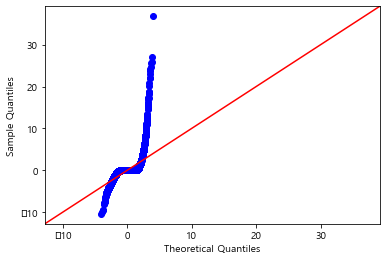

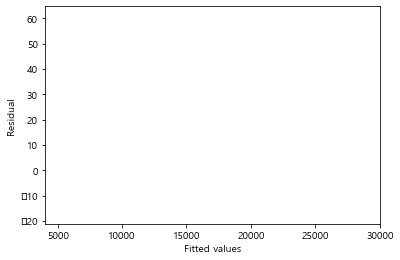

/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


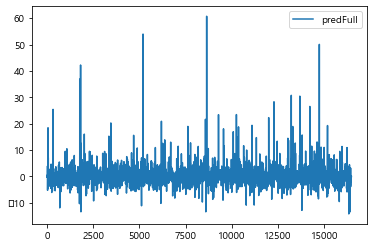

3.013569305066003


In [12]:
res = fittedFullModel.resid
import matplotlib.pyplot as plt
#Q-Q plot # 정규분포확인
fig = sm.qqplot(res, fit=True, line='45')
plt.show()
# residual pattern 확인
 
predY = fittedFullModel.predict(trainX)
 
fig = plt.scatter(predY,res,s=4)
plt.xlim(4000,30000)
plt.xlim(4000,30000)
plt.xlabel('Fitted values')
plt.ylabel('Residual')
plt.show()
 
#검증 데이터에 대한 예측
 
predY2 = fittedFullModel.predict(testX)
 
plt.plot(np.array(testY-predY2),label="predFull")
plt.legend()
plt.show()
 
#MSE 값 구하기
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true=testY,y_pred=predY2)
print(MSE)

## 
## Link ID

In [14]:
# 도로등급 101은 고속도로, 108은 고속도로 연결램프로 제외
detail_road = Detail_road_data[(Detail_road_data['road_rank'] != 101) & (Detail_road_data['road_rank'] != 108)]

# 링크 아이디 추출
detail_road['link_id'] = detail_road['link_id'].astype(int)
link_id = detail_road[['link_id', 'geometry']]
link_id

,link_id,geometry
0,553700043,"MULTILINESTRING ((127.27979 36.24906, 127.2799..."
1,553700273,"MULTILINESTRING ((127.34376 36.24681, 127.3436..."
2,553700308,"MULTILINESTRING ((127.34510 36.24442, 127.3451..."
3,553700340,"MULTILINESTRING ((127.29585 36.22254, 127.2958..."
4,553700456,"MULTILINESTRING ((127.34376 36.24681, 127.3450..."
...,...,...
10841,565110608,"MULTILINESTRING ((127.52063 36.35414, 127.5205..."
10842,565110629,"MULTILINESTRING ((127.50770 36.33864, 127.5048..."
10843,565110680,"MULTILINESTRING ((127.51468 36.35256, 127.5149..."
10844,565110681,"MULTILINESTRING ((127.51787 36.35341, 127.5149..."


In [ ]:
# # 격자 내 링크 추출
# li_list = []
# for i in tqdm(range(gid_data.shape[0])):
#     gid = gid_data['geometry'].iloc[i]
#     cnt_li = Safe_zone_data['geometry'].intersects(gid).sum()
#     li_list.append(cnt_li)
    
# # 링크 데이터 생성
# link = pd.DataFrame()
# link['gid'] = gid_data['gid']
# link['link_id'] = li_list  

In [ ]:
# # 데이터 csv로 저장
# link.to_csv("link_id.csv", index=False)
# link

## 
## 시간대별 추정교통량

시간 범위를 t_0_5, t_6_11, t_12_17, t_18_23 의 변수로 분할<br>
전체 추정 교통량은 t, 승용차 c, 버스 b, 화물차 f로 구분

In [15]:
# 도로등급 101은 고속도로, 108은 고속도로 연결램프로 제외
w_traffic = Weekday_traffic_data[(Weekday_traffic_data['도로등급'] != 101) & (Weekday_traffic_data['도로등급'] != 108)]
w_traffic

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,시간적범위,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량
360,55470163301,103,0.037,금산로,대전광역시,동구,산내동,0,106,93,1,12
361,55470163302,103,0.037,금산로,대전광역시,동구,산내동,0,103,99,0,3
362,55470163101,103,0.090,금산로,대전광역시,동구,산내동,0,106,93,1,12
363,55470163102,103,0.090,금산로,대전광역시,동구,산내동,0,103,99,0,3
364,55470162801,103,0.213,금산로,대전광역시,동구,산내동,0,106,93,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...
479345,56410418902,103,0.040,대전로,대전광역시,동구,삼성동,fulltime,16822,13873,254,2695
479346,56410418901,103,0.040,대전로,대전광역시,동구,삼성동,fulltime,17001,14002,260,2739
479347,56410429802,103,0.043,대전로,대전광역시,동구,삼성동,fulltime,11587,9551,176,1860
479348,56410429801,103,0.043,대전로,대전광역시,동구,삼성동,fulltime,14213,11845,207,2161


In [16]:
#링크 마지막 2자리는 하행/상행 표시로 제외
test = list(w_traffic['상세도로망_LinkID'])
test1 =  [num//100 for num in test]
w_traffic['상세도로망_LinkID'] = test1

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [36]:
c_time = w_traffic[['상세도로망_LinkID','승용차_추정교통량']].groupby('상세도로망_LinkID').mean()
c_time = c_time.reset_index()
b_time = w_traffic[['상세도로망_LinkID','버스_추정교통량']].groupby('상세도로망_LinkID').mean()
b_time = b_time.reset_index()
f_time = w_traffic[['상세도로망_LinkID','화물차_추정교통량']].groupby('상세도로망_LinkID').mean()
f_time = f_time.reset_index()

In [37]:
c_time

,상세도로망_LinkID,승용차_추정교통량
0,553700273,275.88
1,553700308,234.12
2,553700340,47.44
3,553700456,226.62
4,553700458,226.40
...,...,...
10296,565110608,331.08
10297,565110629,667.10
10298,565110680,3.12
10299,565110681,335.64


In [38]:
b_time = b_time.drop(["상세도로망_LinkID"],axis=1,inplace=False)
f_time = f_time.drop(["상세도로망_LinkID"],axis=1,inplace=False)

,버스_추정교통량
0,1.74
1,1.18
2,0.02
3,1.20
4,1.18
...,...
10296,3.76
10297,14.00
10298,0.00
10299,3.86


In [43]:
cb = pd.concat([c_time, b_time], axis=1)
time = pd.concat([cb, f_time], axis=1)
time

,상세도로망_LinkID,승용차_추정교통량,버스_추정교통량,화물차_추정교통량
0,553700273,275.88,1.74,32.08
1,553700308,234.12,1.18,23.76
2,553700340,47.44,0.02,1.18
3,553700456,226.62,1.20,23.38
4,553700458,226.40,1.18,23.12
...,...,...,...,...
10296,565110608,331.08,3.76,48.38
10297,565110629,667.10,14.00,160.46
10298,565110680,3.12,0.00,0.04
10299,565110681,335.64,3.86,49.78


In [50]:
# 링크 데이터에 담기
link_data1 = pd.merge(link_id, time, how='outer', left_on='link_id', right_on='상세도로망_LinkID')
link_data1 = link_data1.drop(["상세도로망_LinkID"],axis=1,inplace=False)
link_data1

,link_id,geometry,승용차_추정교통량,버스_추정교통량,화물차_추정교통량
0,553700043,"MULTILINESTRING ((127.27979 36.24906, 127.2799...",NaN,NaN,NaN
1,553700273,"MULTILINESTRING ((127.34376 36.24681, 127.3436...",275.88,1.74,32.08
2,553700308,"MULTILINESTRING ((127.34510 36.24442, 127.3451...",234.12,1.18,23.76
3,553700340,"MULTILINESTRING ((127.29585 36.22254, 127.2958...",47.44,0.02,1.18
4,553700456,"MULTILINESTRING ((127.34376 36.24681, 127.3450...",226.62,1.20,23.38
...,...,...,...,...,...
10841,565110608,"MULTILINESTRING ((127.52063 36.35414, 127.5205...",331.08,3.76,48.38
10842,565110629,"MULTILINESTRING ((127.50770 36.33864, 127.5048...",667.10,14.00,160.46
10843,565110680,"MULTILINESTRING ((127.51468 36.35256, 127.5149...",3.12,0.00,0.04
10844,565110681,"MULTILINESTRING ((127.51787 36.35341, 127.5149...",335.64,3.86,49.78


## 
## 혼잡빈도강도

In [51]:
# 도로등급 101은 고속도로, 108은 고속도로 연결램프로 제외
c_freq = Congestion_freq_data[(Congestion_freq_data['도로등급'] != 101) & (Congestion_freq_data['도로등급'] != 108)]
c_freq

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,혼잡빈도강도
248,56411962001,102,0.048,천변도시고속도로,대전광역시,대덕구,대화동,100.00
249,56412215001,102,0.048,천변도시고속도로,대전광역시,대덕구,대화동,100.00
250,56411972601,102,0.091,천변도시고속도로,대전광역시,대덕구,대화동,99.42
251,56411972801,102,0.100,천변도시고속도로,대전광역시,대덕구,대화동,99.89
252,56411973201,102,0.105,천변도시고속도로,대전광역시,대덕구,대화동,99.90
...,...,...,...,...,...,...,...,...
18039,56511026502,106,4.422,회남로,대전광역시,동구,대청동,91.70
18040,56511023402,106,6.757,회남로,대전광역시,동구,대청동,62.11
18041,56511023401,106,6.757,회남로,대전광역시,동구,대청동,66.08
18042,56320148202,107,0.659,금남구즉로,대전광역시,유성구,구즉동,9.28


In [52]:
#링크 마지막 2자리는 하행/상행 표시로 제외
link11 = list(c_freq['상세도로망_LinkID'])
link9 = [i//100 for i in link11]
c_freq['상세도로망_LinkID'] = link9

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [53]:
#링크별 혼잡빈도강도 평균값
congestion_freq = c_freq[['상세도로망_LinkID','혼잡빈도강도']].groupby(['상세도로망_LinkID']).mean()
congestion_freq = congestion_freq.reset_index()

In [24]:
# # csv로 저장
# congestion_freq.to_csv("congestion_freq.csv", index=False)
# congestion_freq

,상세도로망_LinkID,혼잡빈도강도
0,553700273,5.340
1,553700308,1.705
2,553700340,88.160
3,553700456,0.425
4,553700458,0.880
...,...,...
9881,565110511,97.375
9882,565110608,0.260
9883,565110629,74.545
9884,565110681,0.460


In [54]:
# 링크 데이터에 담기
link_data2 = pd.merge(link_data1, congestion_freq, how='outer', left_on='link_id', right_on='상세도로망_LinkID')
link_data2 = link_data2.drop(["상세도로망_LinkID"],axis=1,inplace=False)
link_data2

,link_id,geometry,승용차_추정교통량,버스_추정교통량,화물차_추정교통량,혼잡빈도강도
0,553700043,"MULTILINESTRING ((127.27979 36.24906, 127.2799...",NaN,NaN,NaN,NaN
1,553700273,"MULTILINESTRING ((127.34376 36.24681, 127.3436...",275.88,1.74,32.08,5.340
2,553700308,"MULTILINESTRING ((127.34510 36.24442, 127.3451...",234.12,1.18,23.76,1.705
3,553700340,"MULTILINESTRING ((127.29585 36.22254, 127.2958...",47.44,0.02,1.18,88.160
4,553700456,"MULTILINESTRING ((127.34376 36.24681, 127.3450...",226.62,1.20,23.38,0.425
...,...,...,...,...,...,...
10841,565110608,"MULTILINESTRING ((127.52063 36.35414, 127.5205...",331.08,3.76,48.38,0.260
10842,565110629,"MULTILINESTRING ((127.50770 36.33864, 127.5048...",667.10,14.00,160.46,74.545
10843,565110680,"MULTILINESTRING ((127.51468 36.35256, 127.5149...",3.12,0.00,0.04,NaN
10844,565110681,"MULTILINESTRING ((127.51787 36.35341, 127.5149...",335.64,3.86,49.78,0.460


## 
## 혼잡시간강도

In [55]:
# 도로등급 101은 고속도로, 108은 고속도로 연결램프로 제외
c_time = Congestion_time_data[(Congestion_time_data['도로등급'] != 101) & (Congestion_time_data['도로등급'] != 108)]
c_time

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,혼잡시간강도
248,56411962001,102,0.048,천변도시고속도로,대전광역시,대덕구,대화동,100.00
249,56412215001,102,0.048,천변도시고속도로,대전광역시,대덕구,대화동,100.00
250,56411972601,102,0.091,천변도시고속도로,대전광역시,대덕구,대화동,99.88
251,56411972801,102,0.100,천변도시고속도로,대전광역시,대덕구,대화동,99.95
252,56411973201,102,0.105,천변도시고속도로,대전광역시,대덕구,대화동,99.98
...,...,...,...,...,...,...,...,...
18039,55481011502,106,0.580,대둔산로,대전광역시,중구,산성동,17.96
18040,55480418301,106,0.738,대둔산로,대전광역시,중구,산성동,98.24
18041,55480418302,106,0.738,대둔산로,대전광역시,중구,산성동,98.81
18042,55481303401,106,0.041,대둔산로,대전광역시,중구,유천1동,99.37


In [56]:
#링크 마지막 2자리는 하행/상행 표시로 제외
link11 = list(c_time['상세도로망_LinkID'])
link9 = [i//100 for i in link11]
c_time['상세도로망_LinkID'] = link9

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [57]:
#링크별 혼잡시간강도 평균값
congestion_time = c_time[['상세도로망_LinkID','혼잡시간강도']].groupby(['상세도로망_LinkID']).mean()
congestion_time = congestion_time.reset_index()

In [29]:
# # csv로 저장
# congestion_time.to_csv("congestion_time.csv", index=False)
# congestion_time

,상세도로망_LinkID,혼잡시간강도
0,553700273,15.250
1,553700308,4.540
2,553700340,92.470
3,553700456,1.575
4,553700458,3.995
...,...,...
9881,565110511,98.820
9882,565110608,2.225
9883,565110629,79.340
9884,565110681,3.235


In [58]:
# 링크 데이터에 담기
link_data = pd.merge(link_data2, congestion_time, how='inner', left_on='link_id', right_on='상세도로망_LinkID')
link_data = link_data.drop(["상세도로망_LinkID"],axis=1,inplace=False)
link_data

,link_id,geometry,승용차_추정교통량,버스_추정교통량,화물차_추정교통량,혼잡빈도강도,혼잡시간강도
0,553700273,"MULTILINESTRING ((127.34376 36.24681, 127.3436...",275.88,1.74,32.08,5.340,15.250
1,553700308,"MULTILINESTRING ((127.34510 36.24442, 127.3451...",234.12,1.18,23.76,1.705,4.540
2,553700340,"MULTILINESTRING ((127.29585 36.22254, 127.2958...",47.44,0.02,1.18,88.160,92.470
3,553700456,"MULTILINESTRING ((127.34376 36.24681, 127.3450...",226.62,1.20,23.38,0.425,1.575
4,553700458,"MULTILINESTRING ((127.34504 36.24455, 127.3451...",226.40,1.18,23.12,0.880,3.995
...,...,...,...,...,...,...,...
9881,565110511,"MULTILINESTRING ((127.49828 36.35202, 127.4981...",197.44,2.88,43.62,97.375,98.820
9882,565110608,"MULTILINESTRING ((127.52063 36.35414, 127.5205...",331.08,3.76,48.38,0.260,2.225
9883,565110629,"MULTILINESTRING ((127.50770 36.33864, 127.5048...",667.10,14.00,160.46,74.545,79.340
9884,565110681,"MULTILINESTRING ((127.51787 36.35341, 127.5149...",335.64,3.86,49.78,0.460,3.235


In [62]:
link_data.columns

Index(['link_id', 'geometry', '승용차_추정교통량', '버스_추정교통량', '화물차_추정교통량', '혼잡빈도강도',
       '혼잡시간강도'],
      dtype='object')

## 
## 최종 도로데이터

In [31]:
# link_data = gpd.GeoDataFrame(link_data, geometry='geometry')

In [63]:
road_list = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    tf = link_data['geometry'].intersects(gid)
    g = link_data[['승용차_추정교통량', '버스_추정교통량', '화물차_추정교통량', '혼잡빈도강도', '혼잡시간강도']].loc[tf]
    g1 = g.mean()
    road_list.append(g1)

100%|██████████| 54912/54912 [40:40<00:00, 22.50it/s] 


In [64]:
road_gid = pd.DataFrame()
road_gid['gid'] = gid_data['gid']
road = pd.DataFrame(road_list)
road_data = pd.concat([road_gid, road],axis=1)

In [65]:
# csv로 저장
road_data.to_csv("도로데이터정제.csv", index=False)

In [66]:
road_data = pd.read_csv('도로데이터정제.csv')
road_data

,gid,승용차_추정교통량,버스_추정교통량,화물차_추정교통량,혼잡빈도강도,혼잡시간강도
0,다마846996,NaN,NaN,NaN,NaN,NaN
1,다마847995,NaN,NaN,NaN,NaN,NaN
2,다마847996,NaN,NaN,NaN,NaN,NaN
3,다마847997,NaN,NaN,NaN,NaN,NaN
4,다마847998,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
54907,라바052223,NaN,NaN,NaN,NaN,NaN
54908,라바052224,NaN,NaN,NaN,NaN,NaN
54909,라바053222,NaN,NaN,NaN,NaN,NaN
54910,라바053223,NaN,NaN,NaN,NaN,NaN


In [67]:
road_data.value_counts()

gid       승용차_추정교통량  버스_추정교통량   화물차_추정교통량  혼잡빈도강도    혼잡시간강도 
라바036236  27.220     0.880000   9.34       90.98500  93.0150    1
다바884118  613.840    7.260000   101.86     12.31000  42.0200    1
다바883207  756.740    11.180000  148.18     4.50000   11.3450    1
다바883199  18.560     0.020000   0.68       56.71000  92.2500    1
다바883198  18.560     0.020000   0.68       56.71000  92.2500    1
                                                               ..
다바923192  133.440    0.453333   16.64      51.68000  74.1300    1
다바923191  165.500    0.640000   21.84      50.04000  71.1400    1
다바923189  176.255    1.165000   17.79      77.78875  93.0675    1
다바923188  93.630     0.160000   6.71       84.10250  94.4700    1
다바778093  4.800      0.000000   0.18       78.21000  89.6800    1
Length: 11333, dtype: int64

In [30]:
final_data = pd.merge(final7, road_data, how='inner', on='gid')
final_data

,gid,geometry,cars_cnt,acci_cnt,safe_zone,CW_cnt,traffic_sign,traffic_cctv,vehicle_light,walking_light,...,b_traf_0_5,b_traf_6_11,b_traf_12_17,b_traf_18_23,f_traf_0_5,f_traf_6_11,f_traf_12_17,f_traf_18_23,혼잡빈도강도,혼잡시간강도
0,다마846996,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ...",0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,다마847995,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ...",0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,다마847996,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ...",0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,다마847997,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ...",0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,다마847998,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ...",0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54907,라바052223,"MULTIPOLYGON (((127.55799 36.39818, 127.55799 ...",0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54908,라바052224,"MULTIPOLYGON (((127.55799 36.39908, 127.55799 ...",0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54909,라바053222,"MULTIPOLYGON (((127.55910 36.39727, 127.55910 ...",0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54910,라바053223,"MULTIPOLYGON (((127.55910 36.39818, 127.55910 ...",0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
final_data.to_csv("merged_data.csv", index=False)

## 
## 교통노드 링크

In [3]:
# 노드타입 108번은 IC 및 JC로 제외 
t_node = Traffic_node_data[(Traffic_node_data['NODE_TYPE'] != '108')]
t_node

,NODE_ID,NODE_TYPE,NODE_NAME,TURN_P,REMARK,geometry
0,1860000303,101,두마IC,0,None,MULTIPOINT (127.26479 36.27539)
1,1850000703,101,서대전IC,0,None,MULTIPOINT (127.31957 36.28751)
2,1860000304,101,삿갓집입구,0,None,MULTIPOINT (127.28988 36.26759)
3,1860000602,101,방동대교앞,0,None,MULTIPOINT (127.30941 36.28333)
4,1860000501,101,방동사거리,0,None,MULTIPOINT (127.30034 36.28004)
...,...,...,...,...,...,...
2630,1850076200,101,기성초등학교입구,1,비보호좌,MULTIPOINT (127.33618 36.25065)
2631,1850076300,101,승암골입구,1,비보호,MULTIPOINT (127.33880 36.25352)
2632,1850076400,104,매노교,0,교량,MULTIPOINT (127.33942 36.25403)
2633,1850077200,101,사진개정류장앞,1,비보호좌,MULTIPOINT (127.34582 36.26184)


In [4]:
t_node = t_node[['NODE_ID', 'geometry', 'NODE_TYPE']]

In [5]:
t_node.rename(columns = {'geometry' : 'point'}, inplace=True)
t_node

/opt/app-root/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,NODE_ID,point,NODE_TYPE
0,1860000303,MULTIPOINT (127.26479 36.27539),101
1,1850000703,MULTIPOINT (127.31957 36.28751),101
2,1860000304,MULTIPOINT (127.28988 36.26759),101
3,1860000602,MULTIPOINT (127.30941 36.28333),101
4,1860000501,MULTIPOINT (127.30034 36.28004),101
...,...,...,...
2630,1850076200,MULTIPOINT (127.33618 36.25065),101
2631,1850076300,MULTIPOINT (127.33880 36.25352),101
2632,1850076400,MULTIPOINT (127.33942 36.25403),104
2633,1850077200,MULTIPOINT (127.34582 36.26184),101


In [ ]:
#링크의 최고 제한속도 MAX_SPD
#통행제한차량 REST_VEH
#통과제한하중 REST_W
#통과제한높이 REST_H
#도로유형 ROAD_TYPE

In [6]:
#고속도로와, 사용되지 않는 도로 삭제
t_link = Traffic_link_data[(Traffic_link_data['ROAD_RANK'] != '101') & (Traffic_link_data['ROAD_USE'] != '1')]
t_link

,LINK_ID,F_NODE,T_NODE,ROAD_USE,LANES,ROAD_RANK,ROAD_NAME,MULTI_LINK,CONNECT,MAX_SPD,REST_VEH,REST_W,REST_H,REMARK,ROAD_TYPE,ROAD_NO,geometry
8,1860168100,1865780900,1860000300,0,2.0,103,일반국도4호선,0,000,80.0,0,0.0,0.0,계백로,000,4,"MULTILINESTRING ((127.27498 36.26966, 127.2783..."
9,1860169900,1860034200,1865783000,0,1.0,104,지족4길,0,000,40.0,0,0.0,0.0,더미분할,000,0,"MULTILINESTRING ((127.31649 36.37427, 127.3171..."
10,1860170000,1865783000,1860034200,0,1.0,104,지족4길,0,000,40.0,0,0.0,0.0,더미분할,000,0,"MULTILINESTRING ((127.31712 36.37479, 127.3171..."
11,1860170100,1865782600,1860002500,0,1.0,104,하들길,0,000,40.0,0,0.0,0.0,더미분할,000,0,"MULTILINESTRING ((127.30267 36.35953, 127.3030..."
12,1860174200,1860002500,1865782600,0,1.0,104,하들길,0,000,40.0,0,0.0,0.0,더미분할,000,0,"MULTILINESTRING ((127.30406 36.36047, 127.3041..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7497,1850233000,1850075800,1850076200,0,2.0,107,벌곡로,0,000,60.0,0,0.0,0.0,None,000,-,"MULTILINESTRING ((127.33397 36.24963, 127.3350..."
7498,1850233500,1850076300,1850076200,0,2.0,107,벌곡로,0,000,60.0,0,0.0,0.0,None,000,-,"MULTILINESTRING ((127.33875 36.25355, 127.3386..."
7499,1850233800,1850076200,1850076300,0,2.0,107,벌곡로,0,000,60.0,0,0.0,0.0,None,000,-,"MULTILINESTRING ((127.33621 36.25060, 127.3363..."
7500,1850233900,1850076400,1850076300,0,2.0,107,벌곡로,0,000,60.0,0,0.0,0.0,None,000,-,"MULTILINESTRING ((127.33939 36.25407, 127.3388..."


In [7]:
t_link = t_link[['LINK_ID', 'F_NODE', 'T_NODE', 'MAX_SPD', 'REST_VEH', 'REST_W', 'REST_H','ROAD_TYPE' , 'geometry']]

In [10]:
node_link = pd.merge(t_link,t_node, left_on = 'F_NODE', right_on = 'NODE_ID')
node_link = pd.merge(node_link,t_node, left_on = 'T_NODE', right_on = 'NODE_ID')

In [11]:
# 격자내에 해당 geometry_y값을 포함하고 있다면 해당 격자들은 
# MAX_SPD,RESt_VEH, REST_W, REST_H, ROAD_TYPE을 가진다

In [12]:
node_link

,LINK_ID,F_NODE,T_NODE,MAX_SPD,REST_VEH,REST_W,REST_H,ROAD_TYPE,geometry,NODE_ID_x,point_x,NODE_TYPE_x,NODE_ID_y,point_y,NODE_TYPE_y
0,1860169900,1860034200,1865783000,40.0,0,0.0,0.0,000,"MULTILINESTRING ((127.31649 36.37427, 127.3171...",1860034200,MULTIPOINT (127.31649 36.37433),101,1865783000,MULTIPOINT (127.31719 36.37480),103
1,1860171100,1860034700,1865783000,40.0,0,0.0,0.0,000,"MULTILINESTRING ((127.31648 36.37524, 127.3171...",1860034700,MULTIPOINT (127.31648 36.37530),101,1865783000,MULTIPOINT (127.31719 36.37480),103
2,1860095100,1860034200,1860034700,40.0,0,0.0,0.0,000,"MULTILINESTRING ((127.31656 36.37433, 127.3165...",1860034200,MULTIPOINT (127.31649 36.37433),101,1860034700,MULTIPOINT (127.31648 36.37530),101
3,1860171600,1865783000,1860034700,40.0,0,0.0,0.0,000,"MULTILINESTRING ((127.31725 36.37481, 127.3172...",1865783000,MULTIPOINT (127.31719 36.37480),103,1860034700,MULTIPOINT (127.31648 36.37530),101
4,1860096600,1860034900,1860034700,40.0,0,0.0,0.0,000,"MULTILINESTRING ((127.31641 36.37562, 127.3164...",1860034900,MULTIPOINT (127.31648 36.37562),101,1860034700,MULTIPOINT (127.31648 36.37530),101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6973,1850178100,1850056200,1850055500,40.0,0,0.0,0.0,000,"MULTILINESTRING ((127.31125 36.23777, 127.3110...",1850056200,MULTIPOINT (127.31125 36.23774),104,1850055500,MULTIPOINT (127.30994 36.23731),104
6974,1850230600,1850074500,1850075100,60.0,0,0.0,0.0,000,"MULTILINESTRING ((127.33023 36.24756, 127.3303...",1850074500,MULTIPOINT (127.33019 36.24760),101,1850075100,MULTIPOINT (127.33187 36.24903),104
6975,1850231000,1850075300,1850075100,60.0,0,43200.0,0.0,003,"MULTILINESTRING ((127.33223 36.24930, 127.3318...",1850075300,MULTIPOINT (127.33226 36.24925),104,1850075100,MULTIPOINT (127.33187 36.24903),104
6976,1850231600,1850075300,1850075800,60.0,0,0.0,0.0,000,"MULTILINESTRING ((127.33227 36.24919, 127.3328...",1850075300,MULTIPOINT (127.33226 36.24925),104,1850075800,MULTIPOINT (127.33395 36.24969),101


## 
## 지적도에서 도로만 추출

In [ ]:
Continuous_data['type'] = Continuous_data['JIBUN'].str[-1]
Continuous_data

In [ ]:
road_df = Continuous_data[Continuous_data['type'] == '도']
road_df

In [ ]:
# road_df.to_file('대전_지적도_도로.geojson',  driver='GeoJSON', index=False, header=True)

In [ ]:
road_list1 = []
for i in tqdm(range(gid_data.shape[0])):
    gid = gid_data['geometry'].iloc[i]
    a = road_df['geometry'].intersects(gid).sum()
    road_list1.append(a)

In [ ]:
road_d = pd.DataFrame()
road_d['gid'] = gid_data['gid']
road_d['road'] = road_list1

In [ ]:
# road_d.loc[data['road']>0 ,['road']] = 1

In [ ]:
# csv로 저장
road_d.to_csv("격자내도로.csv", index=False)